In [1]:
import librosa
import librosa.display
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque
import IPython.display 
from IPython.display import clear_output
from functools import partial
import scipy

In [2]:
from app.core.stream_processor import sp
from app.core.online_dtw import OLTW
from app.config import *

STFT kernels created, time used = 0.0099 seconds
STFT filter created, time used = 0.0006 seconds
Mel filter created, time used = 0.0006 seconds


/Users/maclab/.pyenv/versions/miniforge3-22.11.1-4/envs/rpf/lib/python3.10/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


## Run Test (Live)
You may play the audio file (or instrument) to computer mic stream.

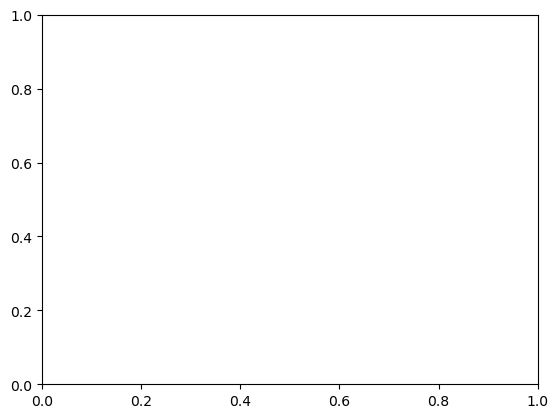

[243/244, 99%] ref: 243, target: 152: 100%|█████████▉| 243/244 [00:06<00:00, 37.61it/s]


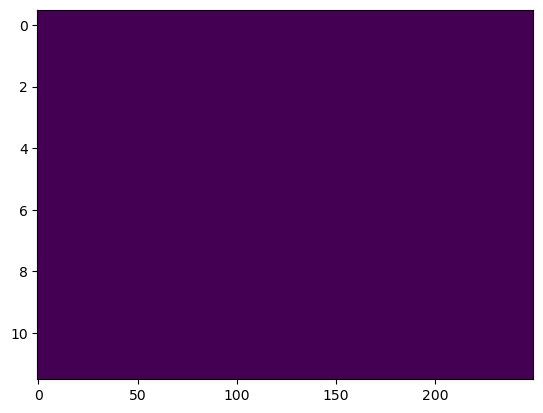

In [3]:
ref_audio_path = "./resources/audio/Haydn_Hob.XVI34_1-1.wav"
duration = int(librosa.get_duration(filename=ref_audio_path)) + 1

import traceback

odtw = OLTW(
    sp,
    ref_audio_path=ref_audio_path,
    window_size=DTW_WINDOW_SIZE,  # window size: 3 sec
    sample_rate=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    max_run_count=3,
    metric=METRIC,
    features=FEATURES,
)
fig = plt.figure()
ax = fig.gca()
hfig = display(fig, display_id=True)
h = ax.imshow(np.zeros((12, int(SAMPLE_RATE/HOP_LENGTH) * duration)), aspect='auto', vmin=0, vmax=1, interpolation='nearest')

try:
    odtw.run(fig, h, hfig)
    
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

In [4]:
x = odtw.ref_pointer
y = odtw.target_pointer
d = odtw.frame_per_seg
wx = min(odtw.w, x)
wy = min(odtw.w, y)
new_acc = np.zeros((wx, wy))
new_len_acc = np.zeros((wx, wy))

x_seg = odtw.ref_features[:, x - d : x].T  # [d, 12]
y_seg = odtw.target_features[:, y - wy : y].T  # [wy, 12]

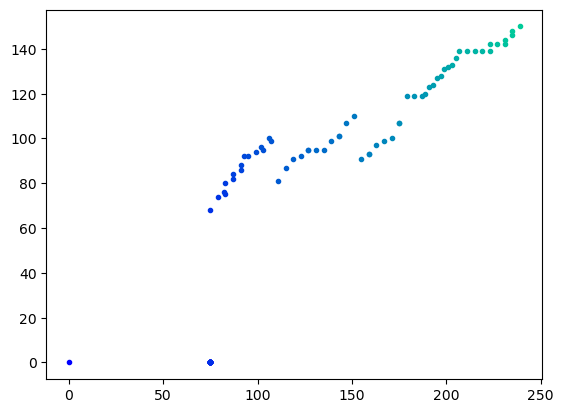

In [5]:
x,y  = zip(*odtw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('winter', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color=cmap(n%100))

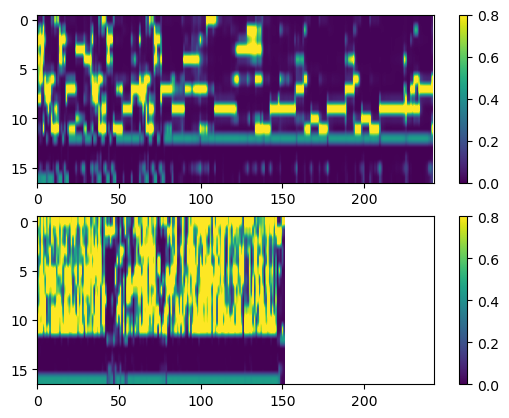

In [6]:
max_step = np.max((odtw.ref_pointer, odtw.target_pointer))
# max_step = np.min((odtw.ref_pointer, odtw.query_pointer))
plt.subplot(211)
plt.imshow(odtw.ref_features[:, :odtw.ref_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()
plt.subplot(212)
plt.imshow(odtw.target_features[:, :odtw.target_pointer], aspect='auto', vmin=0, vmax=0.8)
plt.xlim(0,max_step)
plt.colorbar()

In [13]:
print(odtw.ref_features[:, :odtw.ref_pointer].max())
print(odtw.target_features[:, :odtw.target_pointer].max())


0.9933072
0.9933071490757153


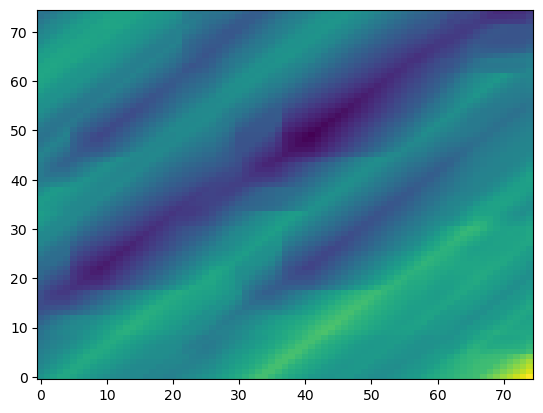

In [14]:
plt.imshow(odtw.acc_dist_matrix.T, aspect='auto', origin='lower')

In [15]:
np.mean(np.abs(odtw.ref_features[:, :odtw.ref_pointer]))

0.16396186

In [16]:
np.mean(np.abs(odtw.target_features[:, :odtw.target_pointer]))

0.16894788352607443

In [17]:
np.min(np.abs(odtw.ref_features)), np.max(np.abs(odtw.ref_features)), np.min(np.abs(odtw.target_features[:, :odtw.target_pointer])), np.max(np.abs(odtw.target_features[:, :odtw.target_pointer]))

(3.1739356e-07, 0.9933072, 2.5276614223912475e-07, 0.9933071490757153)

odtw.target_pointer: 216


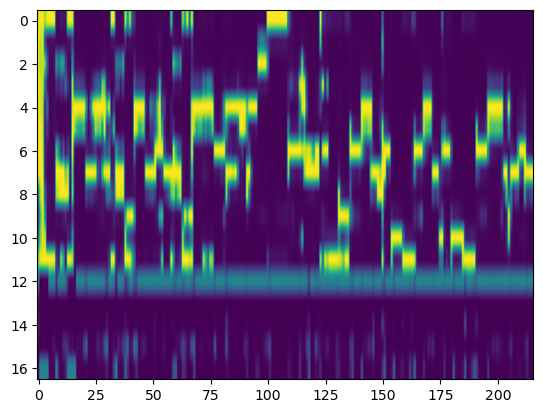

In [18]:
print(f"odtw.target_pointer: {odtw.target_pointer}")
plt.imshow(odtw.target_features[:, :odtw.target_pointer], aspect='auto')

In [46]:
# check remaining query audio queue size
odtw.sp.chroma_buffer.qsize()

1

In [19]:
dist = scipy.spatial.distance.cdist(odtw.ref_features.T, odtw.target_features[:, :odtw.target_pointer].T)  # [d, wy]
plt.figure(figsize=(20, 20))
plt.imshow(dist.T, aspect='auto', origin='lower', interpolation='nearest')
x,y  = zip(*odtw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('magma', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color='r')

NameError: name 'scipy' is not defined

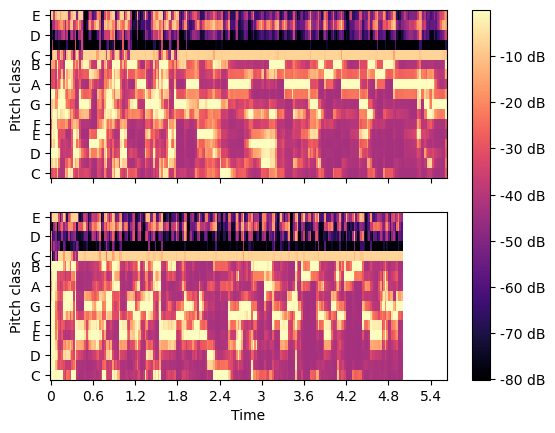

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D1 = librosa.amplitude_to_db(np.abs(odtw.ref_features[:, :odtw.ref_pointer]))
img = librosa.display.specshow(D1, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].label_outer()

D2 = librosa.amplitude_to_db(np.abs(odtw.target_features[:, :odtw.target_pointer]))
img = librosa.display.specshow(D2, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")